# 7.4.1

In [1]:
import numpy as np

x = np.random.rand(10,1,28,28)
x.shape

(10, 1, 28, 28)

In [2]:
x[0].shape

(1, 28, 28)

In [3]:
x[1].shape

(1, 28, 28)

In [1]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch.git


%cd deep-learning-from-scratch

fatal: destination path 'deep-learning-from-scratch' already exists and is not an empty directory.
/content/deep-learning-from-scratch


In [10]:
import sys, os
from common.util import im2col
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


In [6]:
x1= np.random.rand(1,3,7,7)
col1 = im2col(x1, 5,5, stride=1, pad=0)
col1.shape

(9, 75)

In [6]:
class Convolution:

    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN , C , FH , FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + H+ 2 * self.pad -FH / self.stride)
        out_w = int(1 + W+ 2 * self.pad -FW / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)
        
        return out
        
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [4]:

class SimpleConvNet:

    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [9]:

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
train loss:0.005687039013253744
train loss:0.0001615737867232268
train loss:0.008907551209307285
train loss:0.006094189900936183
train loss:0.006704305880001224
train loss:0.0030015917361765625
train loss:0.01592024717414336
train loss:0.0006956399800254893
train loss:0.003114935607634038
train loss:0.0009378438152399526
train loss:0.0030957448734903153
train loss:0.004469928344228304
train loss:0.000474365972984457
train loss:0.009974845031667918
train loss:0.005390231774552897
train loss:0.0016550683644952957
train loss:0.0036627511370985327
train loss:0.0006700717043996688
train loss:0.009490795695830756
train loss:0.0010885865952441275
train loss:0.0044013793067919065
train loss:0.009113241360884988
train loss:0.0015224550463287271
train loss:0.0024239959933629335
train loss:0.0010623392248643468
train loss:0.005203172026327715
train loss:0.015430962011362659
train loss:0.0008811773550405745
train loss:0.0023348145751065186
train loss:0.000748355

NameError: ignored

In [14]:
cd ch07

/content/deep-learning-from-scratch/ch07


In [15]:
ls

apply_filter.py    params.pkl  simple_convnet.py  visualize_filter.py
gradient_check.py  README.md   train_convnet.py


Saved Network Parameters!


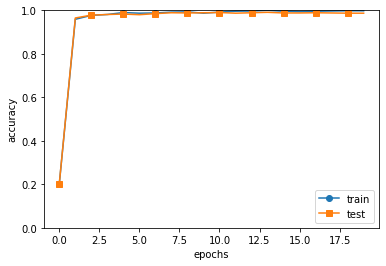

In [18]:
# 매개변수 보존
import pickle
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

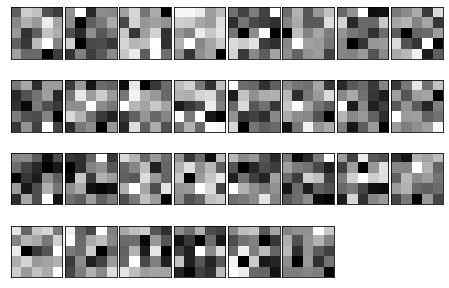

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

In [13]:
cd ch07

/content/deep-learning-from-scratch/ch07


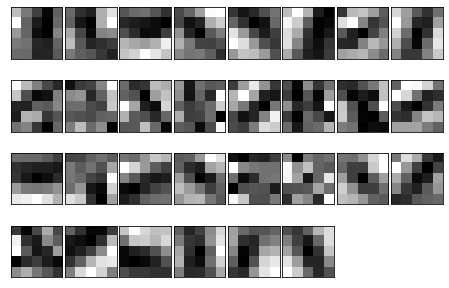

In [15]:
import pickle
# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])